In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
from scipy.stats import norm
from scipy.stats import multivariate_normal
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter
import copy

In [2]:
# Generate synthetic data
# components = ['level','fourrier','ar']
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 1000

AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# Set seed
# np.random.seed(0) # Same seed as in Canari
# np.random.seed(4) # False alarm seed: 4, 5, 8
# np.random.seed(9) # Not clean detection seed: 9
np.random.seed(0)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# # ts = data_generator.generate_time_series()
# data_generator.plot()

In [3]:
# Generate periodic pattern
components_P = ['level','fourrier']

hyperparameters_P = {'level': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'observation': {'error': 0}}
x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
          'var': np.diag([0, 1e-12, 1e-12])}

data_generator_P = generate_one_synthetic_time_series(components = components_P, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters_P, 
                                                    num_steps = num_steps,
                                                    x_init = x_init_P)

# # ts = data_generator.generate_time_series()
# data_generator_P.plot()

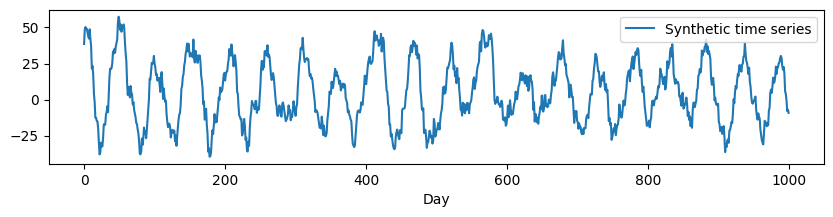

In [4]:
# Add periodic patten
data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()

data_generator.plot()

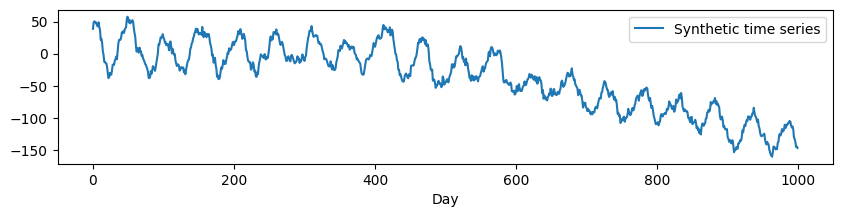

In [5]:
# Add anomaly
anm_pos = 400
anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
# anm_mag = 0
LL_anm_mag = -20
for i in range(num_steps):
    # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
    # if i >= anm_pos:
    #     data_generator.time_series['y'][i] += LL_anm_mag
data_generator.plot()

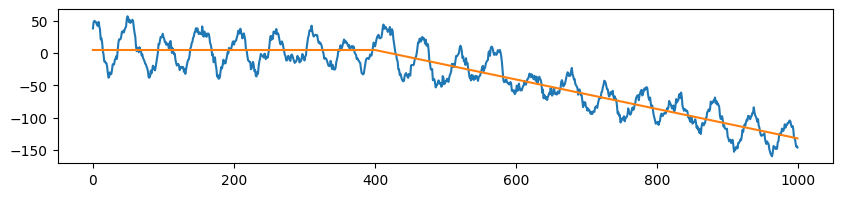

In [6]:
# Plot data_generator.time_series['y'] and its trend
level_baseline = np.zeros_like(data_generator.time_series['y']) + x_init['mu'][0]
for i in range(num_steps):
    if i >= anm_pos:
        level_baseline[i] += anm_mag * (i - anm_pos)

plt.figure(figsize=(10, 2))
plt.plot(data_generator.time_series['y'], label='y')
plt.plot(level_baseline, label='trend_baseline')

In [7]:
# # Save data_generator.time_series['y'] to .csv
# observation_file_paths = ['data/observation.csv', 'data/dummy.csv', 'data/dummy2.csv']
# datetime_file_paths = ['data/datetime.csv', 'data/dummy_datetime.csv', 'data/dummy_datetime2.csv']
# start_date = datetime(2000, 1, 1)
# indices_train_val_test = [1000, -1, -1]
# data_generator.time_step_interval = 7
# data_generator.export_to_csv(indices_train_val_test, observation_file_paths, datetime_file_paths, start_date)

In [8]:
# from src.RL_functions.base_drift_candidate_model import base_drift_candidate_model
from src.RL_functions.actor_critic_kf import *
components = ['trend','fourrier', 'ar']
components_d = ['trend', 'ar']

hyperparameters = {'trend': {'process_error_var': 0},
                    'fourrier': {'period': 52, 'process_error_var': 0},
                    'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                    'observation': {'error': 1e-6}}
hyperparameters_d = {'trend': {'process_error_var': 0, 'phi': 1},
                    'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                    'observation': {'error': 1e-6}}

x_init = {'mu': np.array([5, 0, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
            'var': np.diag([1e-12, 1E-12, 1e-12, 1E-12, 6.36E-05])}
x_init_d = {'mu': np.array([0, 0.0, -0.0621]), \
            'var': np.diag([1e-12, 1e-12, 6.36E-05])}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)

prior_a = [0.998, 0.002]
transition_p = 0
# prior_a = np.array([1, 0])
# transition_p = 1/(52*10)
transition_matrix = np.array([[1-transition_p, 0], [transition_p, 1]])

# baseline_process_error_var_all = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
baseline_process_error_var_all = [1e-6]

x_likelihood_na_all = []
x_likelihood_a_all = []
y_likelihood_na_all = []
y_likelihood_a_all = []
trigger_pos = []

x_last_step = x_init
x_last_step_d = x_init_d

mv_normal_x_all = []
scale_factors_all = []

# # 1-6
# x_samples_mean_all = [0.00167247, 0.00076725, -0.00012462, 0.00028036, 8.32601256e-05, 0.00026317]
# x_samples_cov_all = [0.2947464603971122, 0.0563933392421949, 0.010059685084492303, 0.0017961522236088693, 0.0002923686045498115, 4.728058038118972e-05]
# x_samples_mean_all = [ -0.00012462, 0.00028036, 8.32601256e-05, 0.00026317]
# x_samples_cov_all = [ 0.010059685084492303, 0.0017961522236088693, 0.0002923686045498115, 4.728058038118972e-05]
# # 3-8
# x_samples_mean_all = [-0.0001246218556499242, 0.00028036236100342007, 8.326012562678083e-05, 0.000263174352842544, 0.00022754212234048438, 5.015438641357953e-05]
# x_samples_cov_all = [0.010059685084492303, 0.0017961522236088693, 0.0002923686045498115, 4.728058038118972e-05, 7.019708454952802e-06, 3.238130082615393e-07]
# 1e-6
x_samples_mean_all = [0.000263174352842544]
x_samples_cov_all = [4.728058038118972e-05]

intervene = False
intervention_state = None
for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
    hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
    kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
    x_samples_mean, x_samples_cov = estimate_hs_distribution(components, time_step_interval, hyperparameters, num_steps, x_init, x_init_d, kf, kf_d)
    print(x_samples_mean, x_samples_cov)
    # x_samples_mean, x_samples_cov = x_samples_mean_all[j], x_samples_cov_all[j]
    mv_normal_x = multivariate_normal(mean=x_samples_mean, cov=x_samples_cov, allow_singular=True)
    mv_normal_x_all.append(mv_normal_x)
    scale_factors_all.append(mv_normal_x.pdf(x_samples_mean))

num_steps = 1000
p_na_I_Mj_Yt1 = prior_a[0]
p_a_I_Mj_Yt1 = prior_a[1]
p_Mj_I_Yt_all = []
p_a0_all = []
LL_mu, LT_mu, AR_mu, y_pred_mus = [], [], [], []
LL_var, LT_var, AR_var, y_pred_vars = [], [], [], []
plot_model_index = 0
LLj_mu, LTj_mu, ARj_mu, yj_pred_mus, LLjd_mu, LTjd_mu, ARjd_mu, yjd_pred_mus = [], [], [], [], [], [], [], []
LLj_var, LTj_var, ARj_var, yj_pred_vars, LLjd_var, LTjd_var, ARjd_var, yjd_pred_vars  = [], [], [], [], [], [], [], []
for i in range(num_steps):
    xd_updated_remain_all = []
    x_y_likelihood = []
    for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
        hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
        kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
        x_last_step_d = x_init_d if i==0 else x_last_step_d_all[j]

        intervention_state = copy.deepcopy(x_last_step)
        intervention_state['mu'][0] += x_last_step_d['mu'][0]
        intervention_state['mu'][1] += x_last_step_d['mu'][1]
        intervention_state['var'][0,0] += x_last_step_d['var'][0,0]
        intervention_state['var'][1,1] += x_last_step_d['var'][1,1]
        intervention_state['mu'][-1] = x_last_step_d['mu'][-1]
        # intervention_state['mu'][-1] = 0
        # intervention_state['mu'][-1] = data_generator.time_series['y'][i-1] - x_last_step['mu'][0] - x_last_step['mu'][2] if i > 0 else intervention_state['mu'][-1]
        intervention_state['var'][-1,-1] = x_last_step_d['var'][-1,-1]

        if j==plot_model_index:
            y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na,\
                _, xd_updated_remain, _, _, x_pred, xd_pred, _, yj_pred, _, ar_pred = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data_generator.time_series['y'][i], mv_normal_x_all[j])
        else:
            y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na,\
                _, xd_updated_remain, _, _, _, _, _, _, _, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data_generator.time_series['y'][i], mv_normal_x_all[j])
        x_likelihood_a *= 1/scale_factors_all[j]
        x_likelihood_na *= 1/scale_factors_all[j]

        x_y_likelihood.append([x_likelihood_na.item(), x_likelihood_a.item(), y_likelihood_na.item(), y_likelihood_a.item()])
        xd_updated_remain_all.append(xd_updated_remain)

    x_y_likelihood_array = np.array(x_y_likelihood)
    # p_yt_I_Mj_Yt1 = x_y_likelihood_array[:, 2] * p_na_I_Mj_Yt1 + x_y_likelihood_array[:, 3] * p_a_I_Mj_Yt1
    # p_na_I_Mj_Yt = x_y_likelihood_array[:, 2] * p_na_I_Mj_Yt1 / p_yt_I_Mj_Yt1
    # p_a_I_Mj_Yt = x_y_likelihood_array[:, 3] * p_a_I_Mj_Yt1 / p_yt_I_Mj_Yt1
    p_yt_I_Mj_Yt1 = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 + x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1
    p_na_I_Mj_Yt = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 / p_yt_I_Mj_Yt1
    p_a_I_Mj_Yt = x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1 / p_yt_I_Mj_Yt1

    # Compute probability of taking intervention or not
    # p_action_vector = transition_matrix @ np.vstack((p_na_I_Mj_Yt, p_a_I_Mj_Yt))
    # p_na_I_Mj_Yt1, p_a_I_Mj_Yt1 = p_action_vector[0], p_action_vector[1]
    p_na_I_Mj_Yt1, p_a_I_Mj_Yt1 = prior_a[0], prior_a[1]

    p_Mj_I_Yt = p_yt_I_Mj_Yt1 / np.sum(p_yt_I_Mj_Yt1)   # Probability of each model
    p_a0 = np.sum(p_na_I_Mj_Yt * p_Mj_I_Yt)             # Probability of not requiring intervention by all models

    p_Mj_I_Yt_all.append(p_Mj_I_Yt.tolist())
    p_a0_all.append(p_a0)

    if p_a0 < 0.5:
    # if i == 498:
        intervene = True
        trigger_pos.append(i)

        # intervention_state_mean = np.zeros(len(x_init_d['mu']))
        # intervention_state_cov = np.zeros((len(x_init_d['mu']), len(x_init_d['mu'])))
        # # TODO: how to compute multivariate Gaussian mixture?
        # for n in range(len(baseline_process_error_var_all)):
        #     intervention_state_mean += p_Mj_I_Yt[n] * x_last_step_d_all[n]['mu']
        # for n in range(len(baseline_process_error_var_all)):
        #     # intervention_state_cov += p_Mj_I_Yt[n] * (x_last_step_d_all[n]['var'] + (x_last_step_d_all[n]['mu']-intervention_state_mean).reshape(-1, 1) @ (x_last_step_d_all[n]['mu']-intervention_state_mean).reshape(-1, 1).T)
        #     intervention_state_cov += p_Mj_I_Yt[n] * (x_last_step_d_all[n]['var'])
        # intervention_state = {'mu': intervention_state_mean, 'var': intervention_state_cov}

        # intervention_state = copy.deepcopy(x_last_step)
        # intervention_state['mu'][1] = anm_mag
        # intervention_state['mu'][0] = anm_mag * (i - anm_pos)
        # # intervention_state['mu'][1] = 0
        # # intervention_state['mu'][0] = 0
        # intervention_state['var'][1,1] = 0
        # intervention_state['var'][0,0] = 0

        # intervention_state = copy.deepcopy(x_last_step)
        # intervention_state['mu'][1] = x_init['mu'][1] + anm_mag
        # intervention_state['mu'][0] = x_init['mu'][0] + anm_mag * (i - anm_pos)
        # # intervention_state['mu'][-1] = 0
        # # intervention_state['mu'][-1] = data_generator.time_series['y'][i-1] - x_last_step['mu'][0] - x_last_step['mu'][2] if i > 0 else intervention_state['mu'][-1]

        intervention_state = copy.deepcopy(x_init)
        intervention_state['mu'][1] = x_init['mu'][1] + anm_mag
        intervention_state['mu'][0] = x_init['mu'][0] + anm_mag * (i - 1 - anm_pos)
        intervention_state['mu'][2] = x_last_step['mu'][2]
        intervention_state['mu'][3] = x_last_step['mu'][3]

        # intervention_state = copy.deepcopy(x_last_step)

        # intervention_state['mu'][-1] = data_generator.time_series['y'][i-1] - x_last_step['mu'][0] - x_last_step['mu'][2] if i > 0 else intervention_state['mu'][-1]

        # Update the critic models based on the actual intervention taken
        xd_updated_intervene_all = []
        x_y_likelihood = []
        for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
            hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
            kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
            x_last_step_d = x_init_d if i==0 else x_last_step_d_all[j]

            if j==plot_model_index:
                y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na, xd_updated_intervene, _, x_pred, xd_pred, _, _, yj_pred, _, ar_pred, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data_generator.time_series['y'][i], mv_normal_x_all[j])
            else:
                y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na, xd_updated_intervene, _, _, _, _, _, _, _, _, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data_generator.time_series['y'][i], mv_normal_x_all[j])
            x_y_likelihood.append([x_likelihood_na.item(), x_likelihood_a.item(), y_likelihood_na.item(), y_likelihood_a.item()])
            xd_updated_intervene_all.append(xd_updated_intervene)

        # x_y_likelihood_array = np.array(x_y_likelihood)
        # p_yt_I_Mj_Yt1 = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 + x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1
        # p_na_I_Mj_Yt = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 / p_yt_I_Mj_Yt1
        # p_a_I_Mj_Yt = x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1 / p_yt_I_Mj_Yt1
        # p_na_I_Mj_Yt1, p_a_I_Mj_Yt1 = p_na_I_Mj_Yt, p_a_I_Mj_Yt

        # print(p_na_I_Mj_Yt1, p_a_I_Mj_Yt1)

        p_na_I_Mj_Yt1 = np.zeros_like(p_na_I_Mj_Yt1)+prior_a[0]
        p_a_I_Mj_Yt1 = np.zeros_like(p_na_I_Mj_Yt1)+prior_a[1]
    else:
        intervene = False

    x_pred, y_pred, x_last_step = actor(kf, x_last_step, intervene, intervention_state, data_generator.time_series['y'][i])

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())

    LLj_mu.append(x_pred['mu'][0])
    LTj_mu.append(x_pred['mu'][1])
    ARj_mu.append(x_pred['mu'][-1])
    LLj_var.append(x_pred['var'][0,0])
    LTj_var.append(x_pred['var'][1,1])
    ARj_var.append(x_pred['var'][-1,-1])
    LLjd_mu.append(xd_pred['mu'][0])
    LTjd_mu.append(xd_pred['mu'][1])
    ARjd_mu.append(xd_pred['mu'][-1])
    LLjd_var.append(xd_pred['var'][0,0])
    LTjd_var.append(xd_pred['var'][1,1])
    ARjd_var.append(xd_pred['var'][-1,-1])
    yj_pred_mus.append(yj_pred['mu'].item())
    yj_pred_vars.append(yj_pred['var'].item())
    yjd_pred_mus.append(ar_pred['mu'])
    yjd_pred_vars.append(ar_pred['var'])

    x_last_step_d_all = xd_updated_intervene_all if intervene else xd_updated_remain_all
    # x_last_step_d_all =  xd_updated_remain_all


[0.00026317] 4.728058038118972e-05


(-49.95, 1048.95)

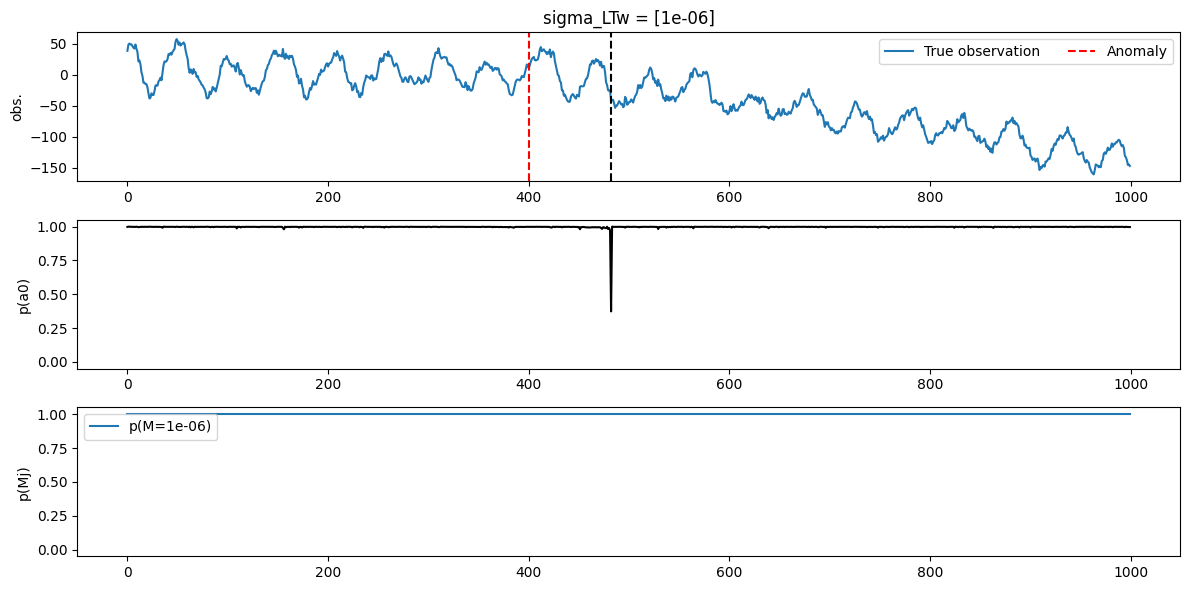

In [9]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) != 0:
    for pos in trigger_pos:
        ax0.axvline(x=pos, color='k', linestyle='--')
ax0.legend(loc='upper right', ncol = 2)
ax0.set_ylabel('obs.')
ax0.set_title('sigma_LTw = ' + str(baseline_process_error_var_all))
# ax0.set_title('sigma_LTw = 0.001')


for j in range(len(baseline_process_error_var_all)):
    # if j == 5:
    #     ax1.plot(data_generator.time_series['timesteps'], p_a0[j], 'k', label='p(a0)')
    ax2.plot(data_generator.time_series['timesteps'], np.transpose(p_Mj_I_Yt_all)[j], label='p(M=' + str(baseline_process_error_var_all[j]) + ')')
ax2.set_ylabel('p(Mj)')
ax2.set_ylim([-0.05, 1.05])
ax2.legend(loc='upper left', ncol = 2)
ax2.set_xlim(ax0.get_xlim())

ax1.plot(data_generator.time_series['timesteps'], p_a0_all, 'k', label='p(a0)')
# ax1.plot(data_generator.time_series['timesteps'], p_na_Mj[2], 'k', label='p(a0)')
ax1.set_ylabel('p(a0)')
ax1.set_ylim([-0.05, 1.05])
# Set xlim as the same as ax0
ax1.set_xlim(ax0.get_xlim())

Text(0, 0.5, 'AR')

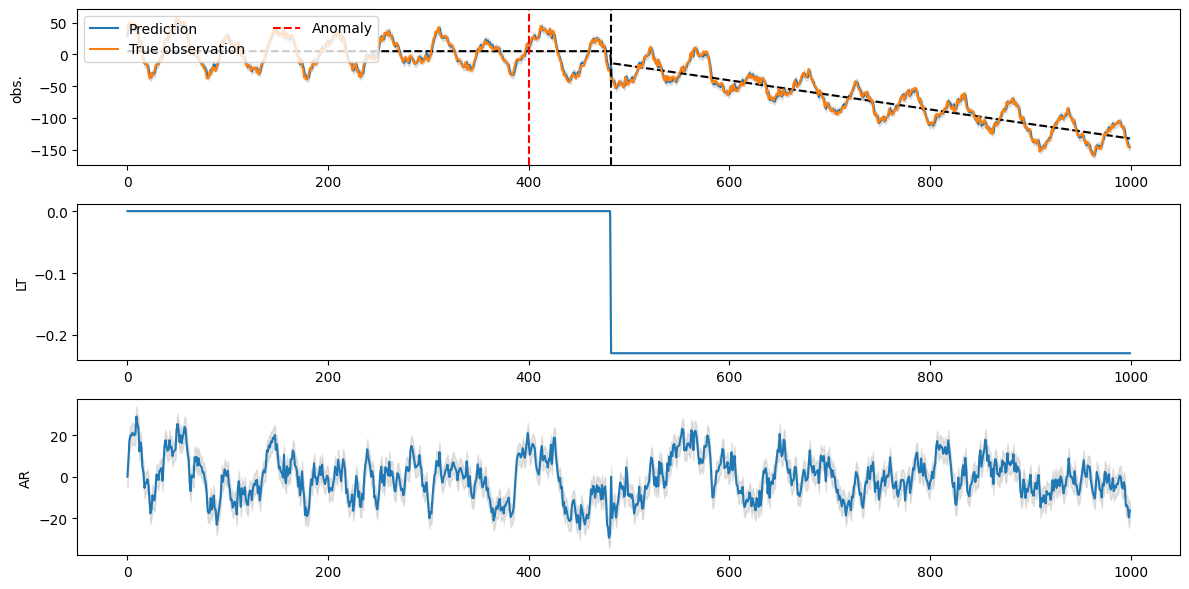

In [10]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], y_pred_mus, label='Prediction')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus)-np.sqrt(y_pred_vars), np.array(y_pred_mus)+np.sqrt(y_pred_vars),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], LL_mu, 'k--')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(LL_mu)-np.sqrt(LL_var), np.array(LL_mu)+np.sqrt(LL_var),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle='--')
ax0.legend(loc='upper left', ncol = 2)
ax0.set_ylabel('obs.')

ax1.plot(data_generator.time_series['timesteps'], LT_mu, label='Prediction')
ax1.fill_between(data_generator.time_series['timesteps'], np.array(LT_mu)-np.sqrt(LT_var), np.array(LT_mu)+np.sqrt(LT_var),color='gray', alpha=0.2)
ax1.set_ylabel('LT')

ax2.plot(data_generator.time_series['timesteps'], AR_mu, label='Prediction')
ax2.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
ax2.set_ylabel('AR')

Text(0, 0.5, 'ARd')

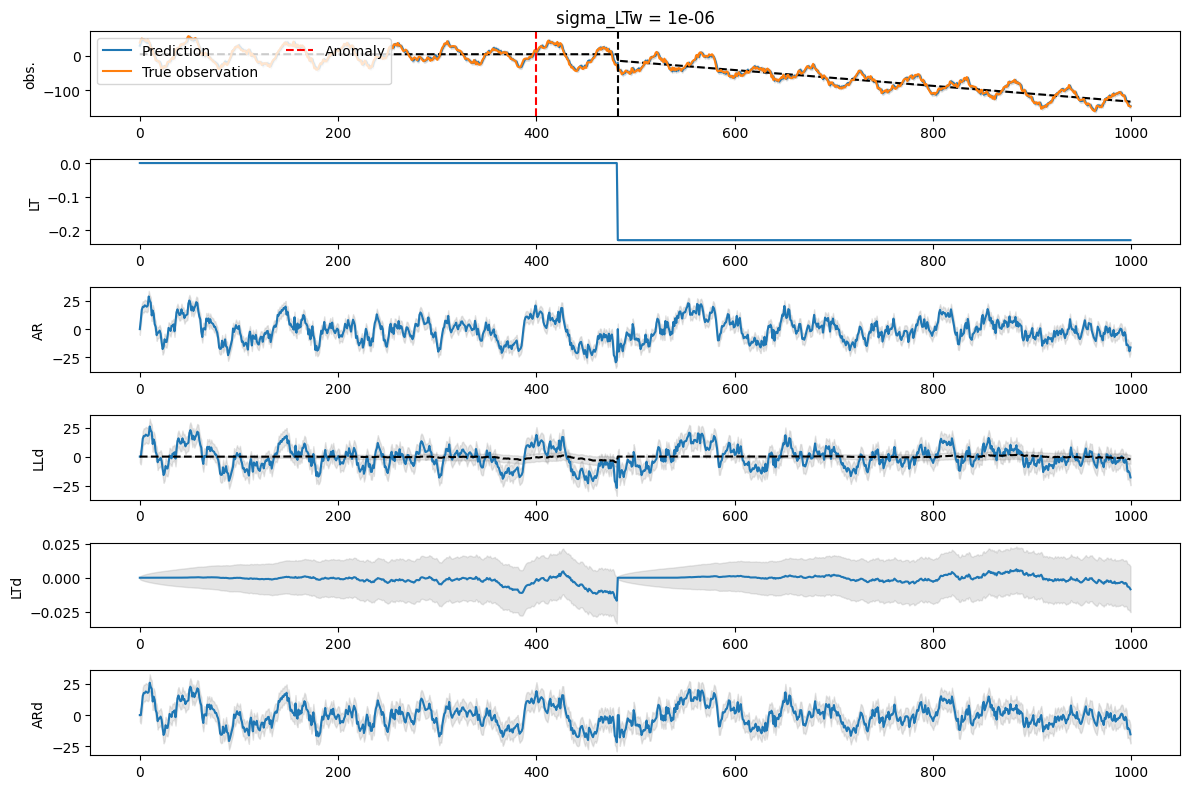

In [11]:
# Plot critic model
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(6, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], yj_pred_mus, label='Prediction')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(yj_pred_mus)-np.sqrt(yj_pred_vars), np.array(yj_pred_mus)+np.sqrt(yj_pred_vars),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], LLj_mu, 'k--')
ax0.fill_between(data_generator.time_series['timesteps'], np.array(LLj_mu)-np.sqrt(LLj_var), np.array(LLj_mu)+np.sqrt(LLj_var),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle='--')
ax0.legend(loc='upper left', ncol = 2)
ax0.set_ylabel('obs.')
ax0.set_title('sigma_LTw = ' + str(baseline_process_error_var_all[plot_model_index]))

ax1.plot(data_generator.time_series['timesteps'], LTj_mu, label='Prediction')
ax1.fill_between(data_generator.time_series['timesteps'], np.array(LTj_mu)-np.sqrt(LTj_var), np.array(LTj_mu)+np.sqrt(LTj_var),color='gray', alpha=0.2)
ax1.set_ylabel('LT')

ax2.plot(data_generator.time_series['timesteps'], ARj_mu, label='Prediction')
ax2.fill_between(data_generator.time_series['timesteps'], np.array(ARj_mu)-np.sqrt(ARj_var), np.array(ARj_mu)+np.sqrt(ARj_var),color='gray', alpha=0.2)
ax2.set_ylabel('AR')

############ Critic model ############
ax3.plot(data_generator.time_series['timesteps'], yjd_pred_mus, label='Prediction')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(yjd_pred_mus)-np.sqrt(yjd_pred_vars), np.array(yjd_pred_mus)+np.sqrt(yjd_pred_vars),color='gray', alpha=0.2)
ax3.plot(data_generator.time_series['timesteps'], LLjd_mu, 'k--')
ax3.fill_between(data_generator.time_series['timesteps'], np.array(LLjd_mu)-np.sqrt(LLjd_var), np.array(LLjd_mu)+np.sqrt(LLjd_var),color='gray', alpha=0.2)
ax3.set_ylabel('LLd')

ax4.plot(data_generator.time_series['timesteps'], LTjd_mu, label='Prediction')
ax4.fill_between(data_generator.time_series['timesteps'], np.array(LTjd_mu)-np.sqrt(LTjd_var), np.array(LTjd_mu)+np.sqrt(LTjd_var),color='gray', alpha=0.2)
ax4.set_ylabel('LTd')

ax5.plot(data_generator.time_series['timesteps'], ARjd_mu, label='Prediction')
ax5.fill_between(data_generator.time_series['timesteps'], np.array(ARjd_mu)-np.sqrt(ARjd_var), np.array(ARjd_mu)+np.sqrt(ARjd_var),color='gray', alpha=0.2)
ax5.set_ylabel('ARd')
